## First look at the data

In [222]:
# this will make sure the root folder is the current working directory
from os import chdir, getcwd
from pyprojroot.here import here
chdir(here())
getcwd()

'/home/avila/devel/learn/ClearCutCostumerClustering'

In [223]:
# libs
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

# set theme for plots
sns.set_theme()


## Read data

In [224]:
def place_column_after(df, col, after):
    """
    Places a specified column after another column in a DataFrame.
    """
    cols = list(df.columns)  # Get current column order
    cols.remove(col)  # Remove the column to be moved
    after_index = cols.index(after) + 1  # Find the position after 'after'
    cols.insert(after_index, col)  # Insert the column at the desired position
    return df[cols]  # Reorder and return the DataFrame

In [225]:
# read data
# ~~~~~~~~~
df = pd.read_csv(
     "./data/01_input/Supermarket_customers.csv",
    delimiter="\t",              # note: \t because its a tab separated and not comma separated file
    parse_dates=["Dt_Customer"], # parse as dates
    date_format='%d-%m-%Y'
) 

# transform columns for sane column names
# (thanks https://stackoverflow.com/a/74643649)
df.columns = (df.columns
                .str.replace('(?<=[a-z])(?=[A-Z])', '_', regex=True)
                .str.lower()
             )


# drop uninformative columns
# ~~~~~~~~~~~~~~~~~~~~~~~~~~
df = df.drop(columns=df.filter(regex="z_").columns)

# Remove unwanted parts from column names
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
df.columns = df.columns.str.replace(r'(_purchases|_products|_prods)', '', regex=True)

# replace alone -> single
# ~~~~~~~~~~~~~~~~~~~~~~~
df["marital_status"] = df["marital_status"].replace("Alone", "Single")

# deal with  absurd and yolo for now (-> single)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
df["marital_status"] = df["marital_status"].replace(["Absurd", "YOLO"], "Single")

# simplify marital status 
# ~~~~~~~~~~~~~~~~~~~~~~~~
marital_status_dict = {
    "Together": "Couple",
    "Married": "Couple",
    "Divorced": "Single",
    "Single": "Single", 
    "Widow": "Single"}

df["marital_status_simple"] = df["marital_status"].replace(marital_status_dict)

# education as numeric 
# ~~~~~~~~~~~~~~~~~~~~~
education_years = {
    "Basic": 9,           # Ensino Fundamental
    "2n Cycle": 12,       # Ensino Médio (High School)
    "Graduation": 16,     # Ensino Superior (Undergraduate)
    "Master": 18,         # Pós-Graduação (Master's Degree)
    "PhD": 22             # Doutorado (Doctorate)
}
df['education_years'] = df['education'].map(education_years)
df = place_column_after(df, "education_years", "education")

# Define an ordered categorical type
education_order = ["Basic", "2n Cycle", "Graduation", "Master", "PhD"]
df['education'] = pd.Categorical(df['education'], categories=education_order, ordered=True)

In [226]:
def summarize_dataframe(df):
    # Container for all statistics
    all_stats = []

    for col in df.columns:
        col_data = df[col]
        num_missing = col_data.isna().sum()
        prop_missing = num_missing / len(col_data)

        if pd.api.types.is_datetime64_any_dtype(col_data):
            # Convert to numeric timestamps for calculations
            col_numeric = col_data.dropna().astype("int64")  # Dates as nanoseconds since epoch
            all_stats.append({
                "variable": col,
                "type": "datetime",
                "mean": pd.to_datetime(col_numeric.mean(), unit="ns") if not col_numeric.empty else None,
                "min": col_data.min(),
                "p05": col_data.quantile(0.05),
                "p50": col_data.median(),
                "p95": col_data.quantile(0.95),
                "max": col_data.max(),
                "num_missing": num_missing,
                "prop_missing": prop_missing
            })
        elif pd.api.types.is_numeric_dtype(col_data):
            all_stats.append({
                "variable": col,
                "type": "numeric",
                "mean": round(col_data.mean(), 4) if not col_data.empty else None,
                "min": col_data.min(),
                "p05": col_data.quantile(0.05),
                "p50": col_data.median(),
                "p95": col_data.quantile(0.95),
                "max": col_data.max(),
                "num_missing": num_missing,
                "prop_missing": prop_missing
            })
        elif isinstance(col_data.dtype, pd.CategoricalDtype) or col_data.dtype == "object":
            all_stats.append({
                "variable": col,
                "type": "categorical",
                "mean": None,
                "min": None,
                "p05": None,
                "p50": None,
                "p95": None,
                "max": None,
                "num_unique": col_data.nunique(),
                "num_missing": num_missing,
                "prop_missing": prop_missing
            })

    # Convert list of dictionaries to a DataFrame
    summary_df = pd.DataFrame(all_stats)
    return summary_df


In [227]:
s1  = summarize_dataframe(df)
s1

,variable,type,mean,min,p05,p50,p95,max,num_missing,prop_missing,num_unique
0,id,numeric,5592.1598,0,576.85,5458.5,10675.05,11191,0,0.000000,NaN
1,year_birth,numeric,1968.8058,1893,1950.0,1970.0,1988.0,1996,0,0.000000,NaN
2,education,categorical,None,None,None,None,None,None,0,0.000000,5.0
3,education_years,numeric,17.1009,9,12.0,16.0,22.0,22,0,0.000000,NaN
4,marital_status,categorical,None,None,None,None,None,None,0,0.000000,5.0
5,income,numeric,52247.2514,1730.0,18985.5,51381.5,84130.0,666666.0,24,0.010714,NaN
6,kidhome,numeric,0.4442,0,0.0,0.0,1.0,2,0,0.000000,NaN
7,teenhome,numeric,0.5062,0,0.0,0.0,1.0,2,0,0.000000,NaN
8,dt_customer,datetime,2013-07-10 10:01:42.857142784,2012-07-30 00:00:00,2012-08-31 00:00:00,2013-07-08 12:00:00,2014-05-22 00:00:00,2014-06-29 00:00:00,0,0.000000,NaN
9,recency,numeric,49.1094,0,4.0,49.0,94.0,99,0,0.000000,NaN


## Predict income for missing values

In [228]:
# for readability (in thousands per month)
df["income"] = df["income"] / 1e3 / 12 


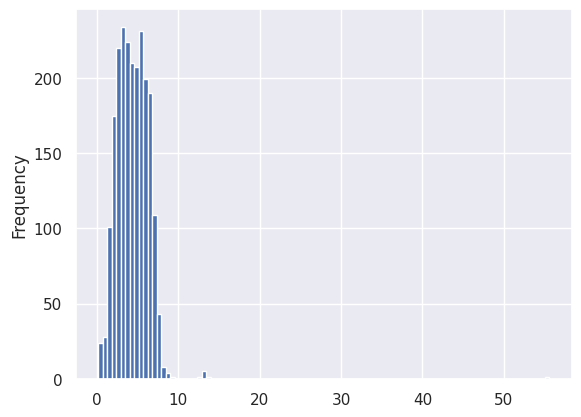

In [229]:
_ = df["income"].plot.hist(bins=100)

In [230]:
# set non plausible data to missing 
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
df.loc[df['id'] == 9432, 'income'] = np.nan # very high value of 666666.66 or something

In [231]:
df.sort_values(by='income', ascending=True).head(6)

,id,year_birth,education,education_years,marital_status,income,kidhome,teenhome,dt_customer,recency,mnt_wines,mnt_fruits,mnt_meat,mnt_fish,mnt_sweet,mnt_gold,num_deals,num_web,num_catalog,num_store,num_web_visits_month,accepted_cmp3,accepted_cmp4,accepted_cmp5,accepted_cmp1,accepted_cmp2,complain,response,marital_status_simple
1245,6862,1971,Graduation,16,Divorced,0.144167,0,0,2014-05-18,65,1,1,3,1,1,1,15,0,0,0,20,0,0,0,0,0,0,0,Single
21,5376,1979,Graduation,16,Married,0.203917,1,0,2013-01-06,42,1,1,1725,1,1,1,15,0,28,0,1,0,0,0,0,0,0,0,Couple
1524,11110,1973,Graduation,16,Single,0.291833,1,0,2013-04-13,56,2,1,1,0,0,1,0,0,0,0,14,0,0,0,0,0,0,0,Single
1846,9931,1963,PhD,22,Married,0.335250,1,1,2014-06-23,29,5,0,1,1,1,1,15,0,0,0,19,0,0,0,0,0,0,0,Couple
1975,10311,1969,Graduation,16,Married,0.369000,0,1,2013-10-05,0,16,4,12,2,4,321,0,25,0,0,1,0,0,0,0,0,0,0,Couple
981,3955,1965,Graduation,16,Divorced,0.405083,0,0,2014-06-22,20,2,1,1,1,0,1,0,0,0,0,14,0,0,0,0,0,0,0,Single


In [232]:
regressors = df.filter(regex=r"year|^educ*|home|mari|mnt|acc|num").columns
regressors

Index(['year_birth', 'education', 'education_years', 'marital_status', 'kidhome', 'teenhome', 'mnt_wines',
       'mnt_fruits', 'mnt_meat', 'mnt_fish', 'mnt_sweet', 'mnt_gold', 'num_deals', 'num_web', 'num_catalog',
       'num_store', 'num_web_visits_month', 'accepted_cmp3', 'accepted_cmp4', 'accepted_cmp5', 'accepted_cmp1',
       'accepted_cmp2', 'marital_status_simple'],
      dtype='object')

In [233]:
## regress income on regressors to estimate missing income
def predict_income(df):
    from sklearn.linear_model import LinearRegression
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import OneHotEncoder

    df = df.copy()

    # Define the list of predictor variables (with categorical columns included)
    regressors = ["year_birth", "education", "marital_status", "kidhome", "teenhome", 
                #"mnt_wines", "mnt_fruits", "mnt_meat", "mnt_fish", "mnt_sweet", "mnt_gold"

    ]
    #regressors = df.filter(regex=r"year|^educ*|home|mari").columns


    # Separate rows with missing and non-missing income
    df_missing = df[df["income"].isna()]
    df_non_missing = df.dropna(subset=["income"])

    # One-hot encode the categorical variables
    df_non_missing_encoded = pd.get_dummies(df_non_missing[regressors], drop_first=True)
    df_missing_encoded = pd.get_dummies(df_missing[regressors], drop_first=True)
    df_all_obs_encoded = pd.get_dummies(df[regressors], drop_first=True)

    # Ensure the training and missing data have the same columns (in case of mismatched categories)
    df_non_missing_encoded, df_missing_encoded = df_non_missing_encoded.align(df_missing_encoded, join="left", axis=1, fill_value=0)

    # Train a linear regression model on non-missing data
    X_train = df_non_missing_encoded
    y_train = df_non_missing["income"]
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Predict missing values
    predicted_income = model.predict(df_missing_encoded)

    # Impute the missing values in the original dataframe
    df.loc[df["income"].isna(), "income"] = predicted_income

    # predict full (for comparison with available info)
    predicted_income_full_df = model.predict(df_all_obs_encoded)
    df["income_pred"] = predicted_income_full_df
    df = place_column_after(df, col="income_pred", after="income")

    df["income_error"] = df["income"] - df["income_pred"]
    df["income_error_relative"] = df["income_error"] / df["income"]

    df = place_column_after(df, "income_error", "income_pred")
    df = place_column_after(df, "income_error_relative", "income_error")

    return df

In [234]:
df = predict_income(df)

In [235]:
# head
df.sort_values(by='income_error_relative', ascending=True).head(20)

,id,year_birth,education,education_years,marital_status,income,income_pred,income_error,income_error_relative,kidhome,teenhome,dt_customer,recency,mnt_wines,mnt_fruits,mnt_meat,mnt_fish,mnt_sweet,mnt_gold,num_deals,num_web,num_catalog,num_store,num_web_visits_month,accepted_cmp3,accepted_cmp4,accepted_cmp5,accepted_cmp1,accepted_cmp2,complain,response,marital_status_simple
1245,6862,1971,Graduation,16,Divorced,0.144167,5.084242,-4.940076,-34.266422,0,0,2014-05-18,65,1,1,3,1,1,1,15,0,0,0,20,0,0,0,0,0,0,0,Single
21,5376,1979,Graduation,16,Married,0.203917,3.413984,-3.210067,-15.742055,1,0,2013-01-06,42,1,1,1725,1,1,1,15,0,28,0,1,0,0,0,0,0,0,0,Couple
1975,10311,1969,Graduation,16,Married,0.369000,5.010933,-4.641933,-12.579764,0,1,2013-10-05,0,16,4,12,2,4,321,0,25,0,0,1,0,0,0,0,0,0,0,Couple
981,3955,1965,Graduation,16,Divorced,0.405083,5.142156,-4.737073,-11.694070,0,0,2014-06-22,20,2,1,1,1,0,1,0,0,0,0,14,0,0,0,0,0,0,0,Single
1524,11110,1973,Graduation,16,Single,0.291833,3.454297,-3.162464,-10.836541,1,0,2013-04-13,56,2,1,1,0,0,1,0,0,0,0,14,0,0,0,0,0,0,0,Single
2214,9303,1976,Graduation,16,Married,0.442083,4.943367,-4.501283,-10.181979,0,1,2013-07-30,12,12,4,7,1,3,5,0,1,0,0,13,0,0,0,0,0,0,0,Couple
1846,9931,1963,PhD,22,Married,0.335250,3.680559,-3.345309,-9.978551,1,1,2014-06-23,29,5,0,1,1,1,1,15,0,0,0,19,0,0,0,0,0,0,0,Couple
774,4303,1957,PhD,22,Together,0.569583,5.390839,-4.821256,-8.464532,0,1,2012-12-08,76,107,2,12,2,2,12,0,0,0,1,20,0,0,0,0,0,0,0,Couple
1328,4246,1982,Master,18,Single,0.546667,5.066633,-4.519966,-8.268231,0,0,2013-12-12,2,67,11,26,4,3,262,0,1,0,1,17,0,0,0,0,0,0,0,Single
1806,6237,1966,PhD,22,Single,0.595333,5.134427,-4.539094,-7.624458,0,2,2013-12-07,92,81,4,33,5,2,291,0,23,1,1,0,0,0,0,0,0,0,0,Single


In [236]:
# tail
df.sort_values(by='income_error_relative', ascending=True).tail(12)

,id,year_birth,education,education_years,marital_status,income,income_pred,income_error,income_error_relative,kidhome,teenhome,dt_customer,recency,mnt_wines,mnt_fruits,mnt_meat,mnt_fish,mnt_sweet,mnt_gold,num_deals,num_web,num_catalog,num_store,num_web_visits_month,accepted_cmp3,accepted_cmp4,accepted_cmp5,accepted_cmp1,accepted_cmp2,complain,response,marital_status_simple
1856,6710,1951,Master,18,Single,4.851417,1.975083,2.876333,0.592885,2,1,2012-11-17,84,68,1,13,3,5,13,1,2,0,4,6,0,0,0,0,0,0,0,Single
164,8475,1973,PhD,22,Married,13.103583,5.214435,7.889148,0.602060,0,1,2014-03-01,98,20,2,1582,1,2,1,15,0,22,0,0,0,0,0,0,0,0,0,Couple
655,5555,1975,Graduation,16,Divorced,12.827000,5.045633,7.781367,0.606640,0,0,2014-02-07,81,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,Single
687,1501,1982,PhD,22,Married,13.400250,5.257537,8.142713,0.607654,0,0,2012-08-04,21,55,16,1622,17,3,4,15,0,28,1,0,0,0,0,0,0,0,0,Couple
728,11171,1965,Master,18,Married,4.746833,1.857552,2.889282,0.608676,2,1,2013-10-11,60,292,3,77,10,3,26,7,6,3,5,7,0,0,0,0,0,0,0,Couple
977,1600,1965,Master,18,Married,4.746833,1.857552,2.889282,0.608676,2,1,2013-10-11,60,292,3,77,10,3,26,7,6,3,5,7,0,0,0,0,0,0,0,Couple
1653,4931,1977,Graduation,16,Together,13.095500,5.085655,8.009845,0.611649,0,0,2013-04-29,13,1,0,1725,2,1,1,0,0,28,0,1,0,0,0,0,0,0,0,Couple
857,425,1985,Graduation,16,Married,4.613083,1.725671,2.887412,0.625918,2,0,2013-02-19,66,374,64,116,84,25,64,3,6,2,11,5,0,0,0,0,0,0,0,Couple
216,7264,1978,2n Cycle,12,Single,4.349583,1.334937,3.014646,0.693089,2,1,2014-05-12,2,12,0,4,0,0,1,1,1,0,2,8,0,0,0,0,0,0,0,Single
701,10196,1978,Graduation,16,Married,5.952250,1.793237,4.159013,0.698729,2,0,2014-03-12,26,212,123,177,15,64,23,2,8,2,8,4,0,0,0,0,0,0,0,Couple


<positron-console-cell-237>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


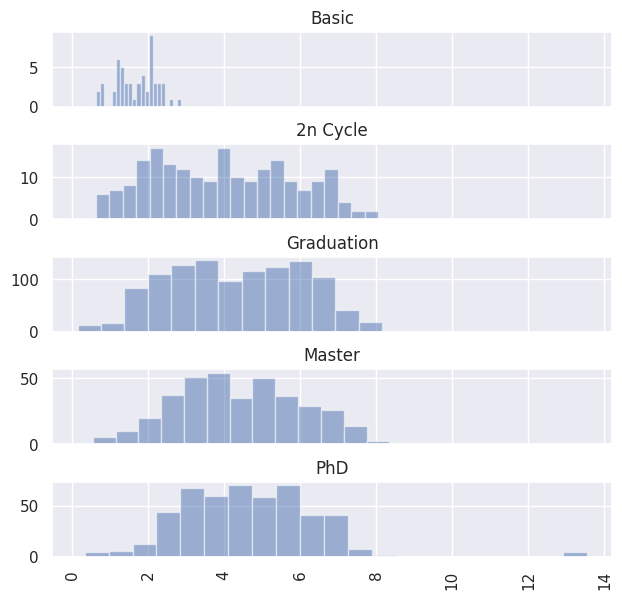

In [237]:
_ = df.hist("income", by="education", bins=21, alpha=0.5, figsize=(7, 7), sharey=False, sharex=True, layout=(5, 1))


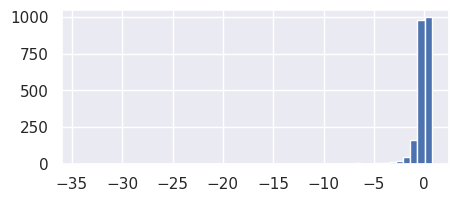

In [238]:
_ = df["income_error_relative"].hist(bins=50, figsize=(5, 2))

In [239]:
# if relative income error is bigger in magnitude than -3, I am assuming the person answered
# monthly income instead of yearly income. 
# there are some very high values as well (which are somewhat plausible, but will impute anyway)

# Set 'income' to missing (NaN) where 'income_error_relative' < -2
df.loc[df['income_error_relative'] < -2, 'income'] = np.nan
df.loc[df['income_error_relative'] > 10, 'income'] = np.nan

# do the prediction again 
df_rawish = df.copy() # first copy the first df, maybe for comparisons.
df = predict_income(df_rawish)

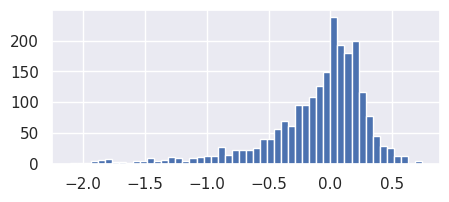

In [240]:
import matplotlib.pyplot as plt
_ = df["income_error_relative"].hist(bins=50, figsize=(5, 2))


- errors are better behaved now.

## EDA

### Correlation heatmap


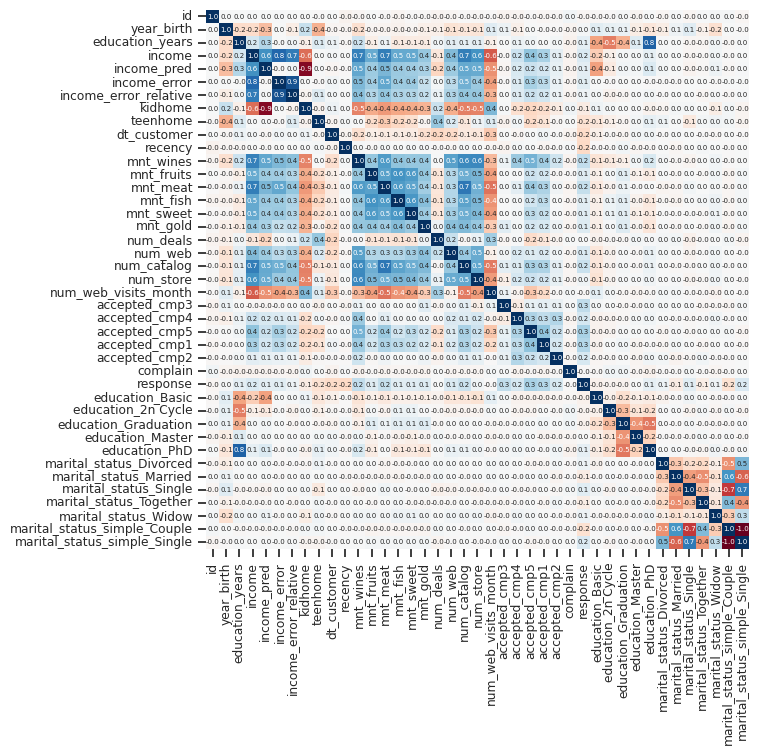

In [241]:
def plot_corr_heatmap(df, font_scale=1, size=7):
    # get correlations 
    df_full_encoded = pd.get_dummies(df, drop_first=False)
    df_corr = df_full_encoded.corr()

    sns.set(font_scale=.8)
    sns.set_style("ticks")

    # heatmap
    fig, ax = plt.subplots(figsize=(size,size))
    sns.heatmap(
        df_corr, 
        cmap='RdBu',
        annot=True,
        #linewidth=.1,
        fmt=".1f",
        annot_kws={"size": 5},
        vmin=-1, vmax=1,
        cbar=False
    )
    plt.show()

plot_corr_heatmap(df)

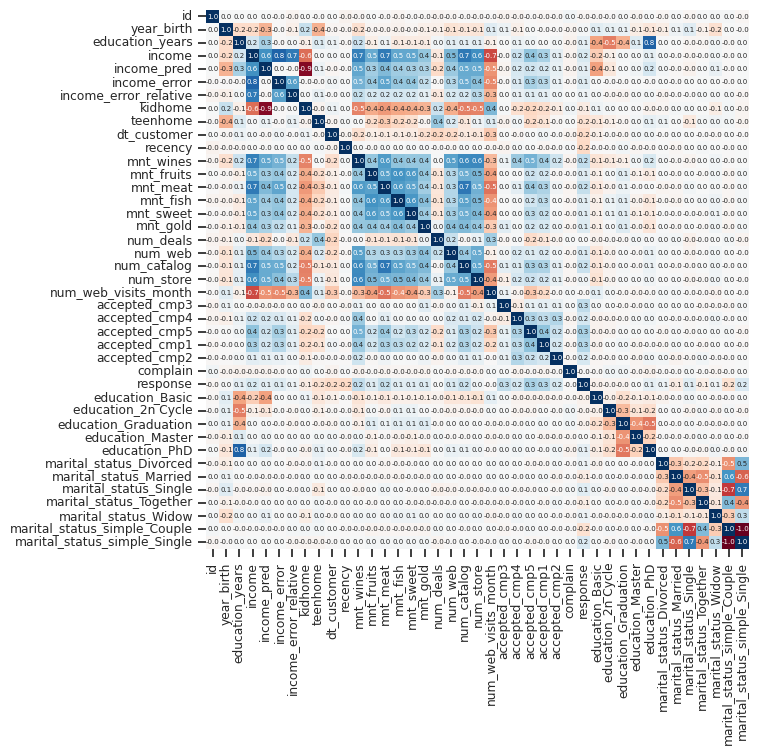

In [242]:
plot_corr_heatmap(df_rawish)

In [243]:
def summary_stats_by_group(df, group_var, target_var):
    
    # Calculate the summary statistics
    summary = df.groupby(group_var)[target_var].agg(
        count="count",  # Count the number of occurrences
        mean="mean",
        min="min",
        max="max",
        p01=lambda x: x.quantile(0.01),
        p10=lambda x: x.quantile(0.10),
        p25=lambda x: x.quantile(0.25),
        p50=lambda x: x.quantile(0.50),
        p75=lambda x: x.quantile(0.75),
        p90=lambda x: x.quantile(0.90),
        p99=lambda x: x.quantile(0.99)
    ).reset_index()

    # Sort by mean value (descending order)
    summary_sorted = summary.sort_values(by="mean", ascending=True)

    return summary_sorted

In [244]:
if "mnt_total" not in df.columns: df["mnt_total"] = df.filter(like="mnt").sum(axis=1)
if "num_total" not in df.columns: df["num_total"] = df.filter(like="num").sum(axis=1)

if "accepted_total" not in df.columns: df["accepted_total"] = df.filter(like="accepted_cmp").sum(axis=1)
if "accepted_any"   not in df.columns: df["accepted_any"]   = df.filter(like="accepted_cmp").sum(axis=1)>0 # at least one
# if cond so that does not run more than once

df.filter(regex="mnt|num|acc").head(n=6)

,mnt_wines,mnt_fruits,mnt_meat,mnt_fish,mnt_sweet,mnt_gold,num_deals,num_web,num_catalog,num_store,num_web_visits_month,accepted_cmp3,accepted_cmp4,accepted_cmp5,accepted_cmp1,accepted_cmp2,mnt_total,num_total,accepted_total,accepted_any
0,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,1617,32,0,False
1,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,27,11,0,False
2,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,776,25,0,False
3,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,53,14,0,False
4,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,422,24,0,False
5,520,42,98,0,42,14,2,6,4,10,6,0,0,0,0,0,716,28,0,False


In [245]:
# summary by education, target variable: income
summary_stats_by_group(df, group_var="education", target_var="income")

<positron-console-cell-245>:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


,education,count,mean,min,max,p01,p10,p25,p50,p75,p90,p99
0,Basic,54,1.733529,0.625000,2.870417,0.688600,1.155267,1.324813,1.799417,2.094875,2.327608,2.863503
1,2n Cycle,203,4.111652,1.127750,8.045583,1.234533,1.948050,2.655708,3.973500,5.425042,6.541417,7.462037
2,Graduation,1127,4.455779,1.170417,13.095500,1.471595,2.237467,3.093125,4.488583,5.806083,6.650100,7.852463
3,Master,370,4.489004,1.387750,13.144417,1.514314,2.544708,3.218333,4.315125,5.549667,6.647892,7.698230
4,PhD,486,4.704866,1.237417,13.533083,1.684262,2.734125,3.401729,4.603000,5.757000,6.751917,8.658008


In [246]:
# summary by education, target variable: mnt_total
summary_stats_by_group(df, group_var="education", target_var="mnt_total")

<positron-console-cell-246>:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


,education,count,mean,min,max,p01,p10,p25,p50,p75,p90,p99
0,Basic,54,81.796296,14,839,15.06,24.0,29.75,57.0,80.0,103.0,624.35
1,2n Cycle,203,496.527094,13,2257,17.02,34.0,56.50,198.0,899.0,1289.0,2048.02
3,Master,370,611.781081,10,2525,12.69,35.0,79.25,387.5,988.0,1615.6,2281.14
2,Graduation,1127,619.898846,5,2524,14.26,35.2,70.00,414.0,1073.0,1535.0,2147.02
4,PhD,486,672.409465,8,2440,10.00,39.0,88.50,493.0,1157.5,1654.0,2114.75


In [247]:
# summary by education, target variable: income
summary_stats_by_group(df, group_var="education", target_var="num_total")

<positron-console-cell-247>:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


,education,count,mean,min,max,p01,p10,p25,p50,p75,p90,p99
0,Basic,54,13.888889,8,36,8.53,11.0,11.25,13.0,15.0,17.0,27.52
1,2n Cycle,203,19.256158,1,46,8.00,11.0,13.00,18.0,24.0,30.0,38.00
3,Master,370,20.105405,3,40,8.00,12.0,14.00,19.0,26.0,30.0,38.00
2,Graduation,1127,20.277728,0,44,9.00,12.0,14.00,20.0,25.0,30.0,38.00
4,PhD,486,21.088477,0,44,8.00,11.5,14.25,21.0,26.0,31.0,39.00


In [248]:
# summary by education, target variable: income
summary_stats_by_group(df, group_var="marital_status", target_var="income")

,marital_status,count,mean,min,max,p01,p10,p25,p50,p75,p90,p99
2,Single,487,4.356605,0.625000,9.477833,1.268785,2.153400,2.985458,4.124500,5.707458,6.784200,7.976080
3,Together,580,4.391303,0.810167,13.533083,1.356697,2.189175,3.026083,4.326417,5.682500,6.533017,7.908943
1,Married,864,4.420281,1.170417,13.400250,1.408518,2.187567,3.079667,4.481292,5.624000,6.620183,7.743887
0,Divorced,232,4.511254,0.795667,12.827000,1.248732,2.369083,3.244542,4.593375,5.729875,6.642733,7.531597
4,Widow,77,4.715309,1.843583,7.135000,2.048467,2.715217,3.750500,4.712583,5.847083,6.581350,7.092757


In [249]:
# summary by education, target variable: mnt_total
summary_stats_by_group(df, group_var="marital_status", target_var="mnt_total")

,marital_status,count,mean,min,max,p01,p10,p25,p50,p75,p90,p99
1,Married,864,590.802083,8,2486,15.63,37.0,68.00,396.5,1001.00,1514.4,2126.00
2,Single,487,605.985626,5,2525,15.00,30.2,71.00,369.0,1101.50,1555.2,2127.30
3,Together,580,608.387931,8,2524,10.79,32.0,69.00,393.5,1039.25,1572.2,2253.05
0,Divorced,232,610.629310,6,2074,8.93,31.0,61.25,395.0,1073.00,1476.5,1885.87
4,Widow,77,738.818182,15,2088,21.08,44.0,138.00,636.0,1156.00,1564.4,1967.92


In [250]:
# summary by education, target variable: num_total
summary_stats_by_group(df, group_var="marital_status", target_var="num_total")

,marital_status,count,mean,min,max,p01,p10,p25,p50,p75,p90,p99
2,Single,487,19.564682,7,38,8.00,11.0,14.0,19.0,24.0,29.0,35.14
3,Together,580,20.077586,1,46,8.00,11.0,14.0,19.0,26.0,30.0,38.00
1,Married,864,20.320602,0,44,9.00,12.0,14.0,20.0,26.0,30.7,38.37
0,Divorced,232,20.724138,0,39,8.00,11.0,14.0,20.0,28.0,31.0,38.00
4,Widow,77,21.584416,8,39,8.76,12.0,16.0,21.0,27.0,30.4,39.00


In [251]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_violin_strip(df, group_var, target_var, figsize=(6,6), jitter=True, cut=0):
    # Create a figure for the plot
    plt.figure(figsize=figsize)

    # Create the violin plot (horizontal)
    ax = sns.violinplot(
        x=target_var, y=group_var, data=df, color="lightblue", cut=cut, split=True
    )
    ax.set(xlabel=None, ylabel=None)

    # Title and labels
    plt.title(f"Distribution of {target_var} \nby {group_var}", loc="left")

    # Show the plot
    plt.tight_layout()
    plt.show()

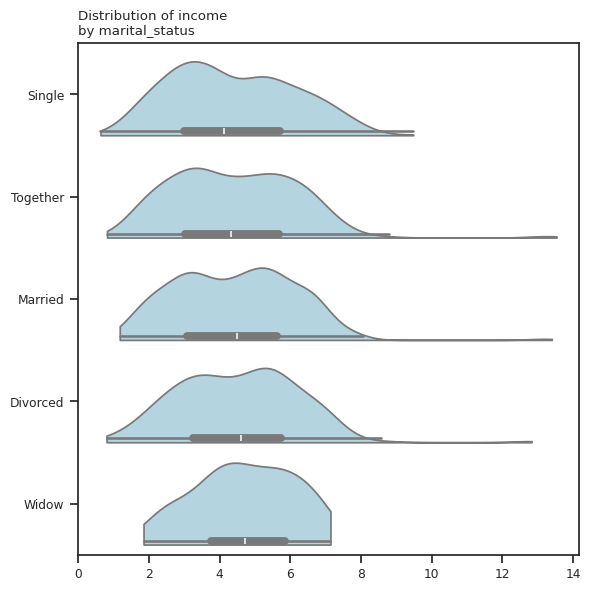

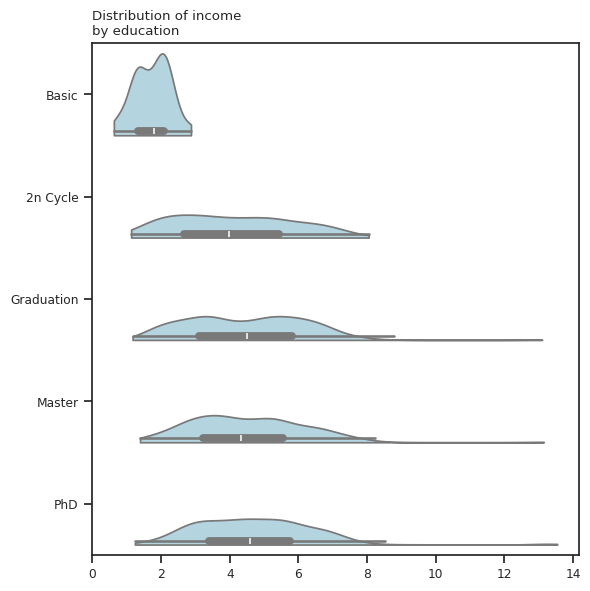

In [252]:
plot_violin_strip(df, group_var="marital_status", target_var="income")
plot_violin_strip(df, group_var="education", target_var="income")

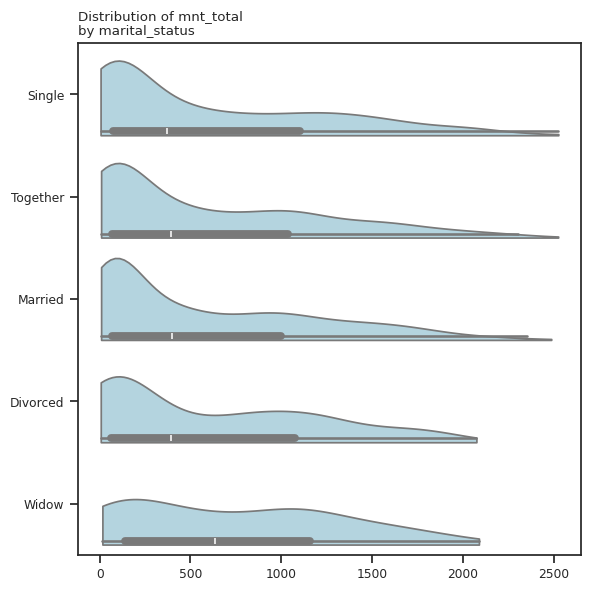

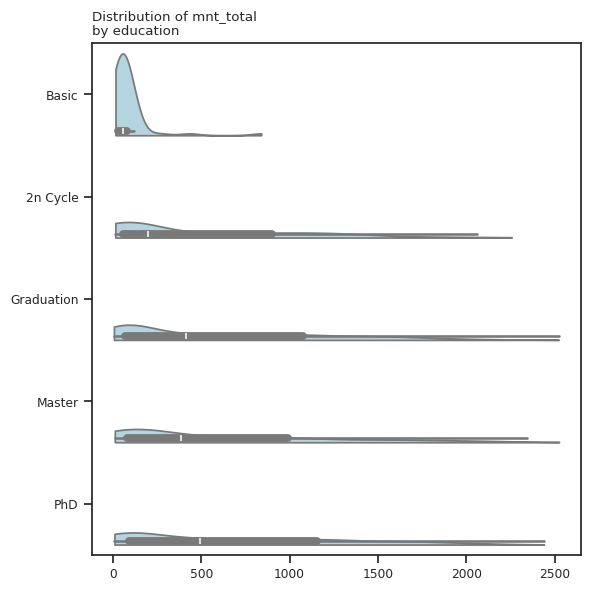

In [254]:
plot_violin_strip(df, group_var="marital_status", target_var="mnt_total")
plot_violin_strip(df, group_var="education", target_var="mnt_total")

In [255]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def visualize_selected_features(df, features, target_var=None, nrows=5, ncols=5, figsize=(20, 20)):
    """
    Visualizes selected features of a DataFrame grouped by a target variable.
    
    Parameters:
    - df (pd.DataFrame): The input dataset.
    - features (list): A list of feature names to visualize.
    - target_var (str): The column name of the target variable
    - nrows (int): Number of rows in the subplot grid. Default is 5.
    - ncols (int): Number of columns in the subplot grid. Default is 5.
    - figsize (tuple): Size of the overall figure. Default is (20, 20).
    """
    # Define the figure and axes for the grid of subplots
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = axes.flatten()
       
    # Loop over each feature and plot based on its type
    for i, feature in enumerate(features):
        if i >= len(axes):  # Skip plotting if axes are exhausted
            break
        
        if df[feature].dtype in ["float64", "int64"] and df[feature].max() > 5:  # Numerical features
            sns.histplot(data=df, x=feature, hue=target_var, kde=True, ax=axes[i])

        elif df[feature].dtype in ["category", "object"]:  # Nominal features
            sns.countplot(data=df, x=feature, hue=target_var, ax=axes[i])

        else:  # Ordinal or other types
            sns.violinplot(data=df, x=target_var, y=feature, ax=axes[i])
        
        # Set the title for the plot
        axes[i].set_title(feature)
        # axes[i].set_yscale("log")  
        axes[i].set(xlabel=None, ylabel=None)
    
    # Hide any remaining unused axes in the grid
    for j in range(len(features), len(axes)):
        fig.delaxes(axes[j])
    

    plt.tight_layout()
    plt.show()

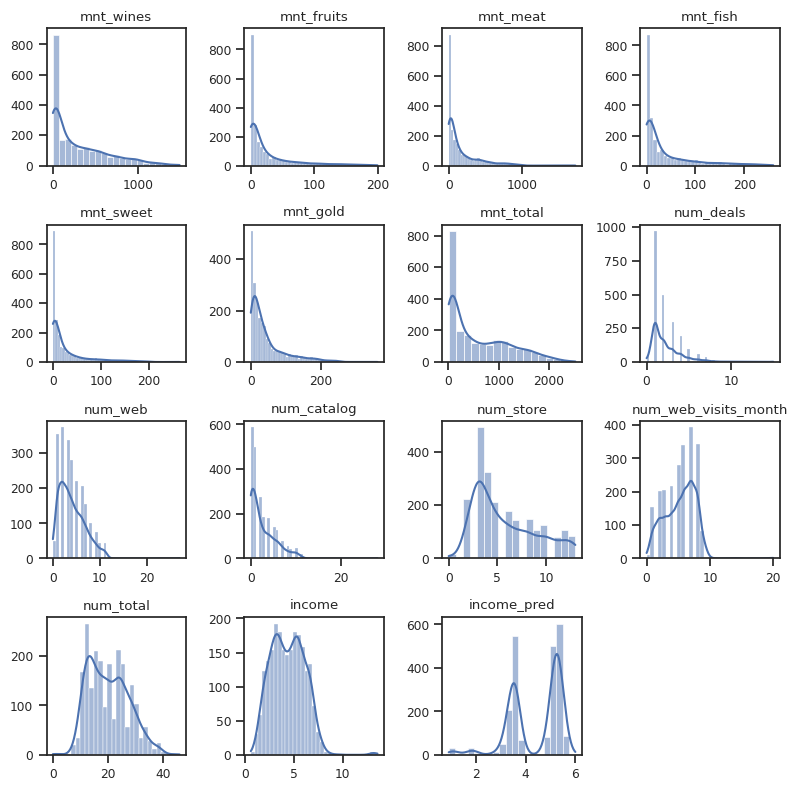

In [256]:
num_features = [
    "mnt_wines",
    "mnt_fruits",
    "mnt_meat",
    "mnt_fish",
    "mnt_sweet",
    "mnt_gold",
    "mnt_total",
    "num_deals", 
    "num_web", 
    "num_catalog", 
    "num_store", 
    "num_web_visits_month",
    "num_total", 
    "income", 
    "income_pred"
]

# Call the function for specific features
visualize_selected_features(
    df=df,
    features=num_features,
    nrows=4, 
    ncols=4, 
    figsize=(8,8)
)

## Deal with Income 

- outlier (very very high value)
- inplausible values: mixing up yearly with monthly income 
  

In [215]:
def trim_columns(df, columns, lower_pct=0.01, upper_pct=0.99):
    """
    Trims specified columns in a DataFrame by capping values at given percentiles.
    
    pandas.DataFrame.clip: Assigns values outside boundary to boundary values. Thresholds can be
    singular values or array like, and in the latter case the clipping is performed element-wise in
    the specified axis.
    
    Parameters:
        df (pd.DataFrame): The input DataFrame.
        columns (str or list): Column(s) to trim.
        lower_pct (float): Lower percentile to trim (e.g., 0.05).
        upper_pct (float): Upper percentile to trim (e.g., 99.5).
    
    Returns:
        pd.DataFrame: DataFrame with specified columns trimmed.
    """
    if isinstance(columns, str):
        columns = [columns]  # Convert single column name to a list

    for col in columns:
        lower = df[col].quantile(lower_pct)
        upper = df[col].quantile(upper_pct)
        df[col] = df[col].clip(lower=lower, upper=upper)

    return df

In [216]:
df = trim_columns(df, "income", lower_pct=0, upper_pct=0.99)

In [217]:
df.to_parquet("data/02_inter/df_01_first_look.parquet")

In [218]:
df.columns

Index(['id', 'year_birth', 'education', 'education_years', 'marital_status', 'income', 'income_pred',
       'income_error', 'income_error_relative', 'kidhome', 'teenhome', 'dt_customer', 'recency', 'mnt_wines',
       'mnt_fruits', 'mnt_meat', 'mnt_fish', 'mnt_sweet', 'mnt_gold', 'num_deals', 'num_web', 'num_catalog',
       'num_store', 'num_web_visits_month', 'accepted_cmp3', 'accepted_cmp4', 'accepted_cmp5', 'accepted_cmp1',
       'accepted_cmp2', 'complain', 'response', 'marital_status_simple', 'mnt_total', 'num_total',
       'accepted_total', 'accepted_any'],
      dtype='object')